## Preprocessing of Mammographic images

### Importing libraries

In [1]:
%pylab inline
import cv2
import numpy as np
import dicom
import pandas as pd
import os
import matplotlib.pyplot as plt
from gzip import GzipFile

Populating the interactive namespace from numpy and matplotlib


/Users/palakagrawal/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


### Fetching current path

In [3]:
#Current path is fetched
cur_path = os.path.dirname(os.getcwd())
print(cur_path)

/Users/palakagrawal/Desktop/Courses/ADS/agrawal_palak_spring18_ads/project


In [4]:
def gen_maxval_mask(dtype):
    '''Generate a maxval binary mask for a numpy uintX dtype
    '''
    if dtype not in [np.uint8, np.uint16, np.uint32, np.uint64]:
        raise Exception
    return np.array([-1]).astype(dtype)[0]

### Converting to single channel gray scale image

In [5]:
mammo_img = cv2.imread(cur_path + '/outcome/Calc_Data/44.jpg', cv2.IMREAD_GRAYSCALE)

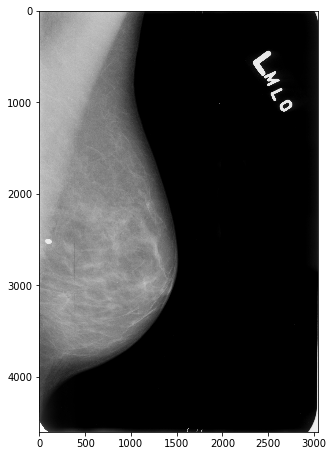

In [6]:
fig,ax = subplots()
fig.set_size_inches([5, 9])
ax.imshow(mammo_img, cmap='gray')
plt.savefig(cur_path+'/outcome/GreyScaleImg.jpg',bbox_inches="tight")

### Smoothing the image and removing the noise

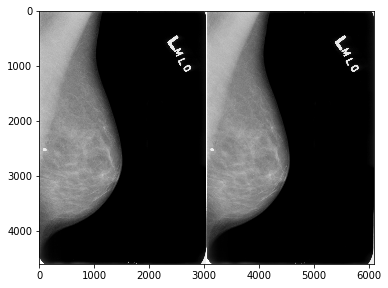

In [7]:
mammo_med_blurred = cv2.medianBlur(mammo_img, 3)  # <<= para to tune!
fig,ax = subplots()
fig.set_size_inches([6, 6])
res = hstack((mammo_img, mammo_med_blurred))
ax.imshow(res, cmap='gray')
plt.savefig(cur_path+'/outcome/MedianBlurImg.jpg',bbox_inches="tight")

### Thresholding the image
- GrayScaled image still has at least 255 values.
- Thresholding at the most basic level converts everything to white or black, based on a threshold value.

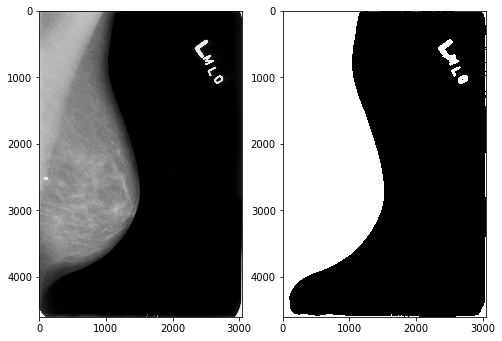

In [8]:
global_threshold = 18  # from Nagi thesis. <<= para to tune!
_, mammo_binary = cv2.threshold(mammo_med_blurred, global_threshold, 
                                maxval=255, type=cv2.THRESH_BINARY)
fig,axes = subplots(1, 2)
fig.set_size_inches([8, 6])
axes[0].imshow(mammo_med_blurred, cmap='gray')
axes[1].imshow(mammo_binary, cmap='gray')
plt.savefig(cur_path+'/outcome/ThresholdImg.jpg')

### Suppressing the Artifact number

In [9]:
def select_largest_obj(img_bin, lab_val=255, fill_holes=False, 
                       smooth_boundary=False, kernel_size=15):
    n_labels, img_labeled, lab_stats, _ = cv2.connectedComponentsWithStats(
        img_bin, connectivity=8, ltype=cv2.CV_32S)
    largest_obj_lab = np.argmax(lab_stats[1:, 4]) + 1
    largest_mask = np.zeros(img_bin.shape, dtype=np.uint8)
    largest_mask[img_labeled == largest_obj_lab] = lab_val
    if fill_holes:
        bkg_locs = where(img_labeled == 0)
        bkg_seed = (bkg_locs[0][0], bkg_locs[1][0])
        img_floodfill = largest_mask.copy()
        h_, w_ = largest_mask.shape
        mask_ = np.zeros((h_ + 2, w_ + 2), dtype=np.uint8)
        cv2.floodFill(img_floodfill, mask_, seedPoint=bkg_seed, newVal=lab_val)
        holes_mask = cv2.bitwise_not(img_floodfill)  # mask of the holes.
        largest_mask = largest_mask + holes_mask
    if smooth_boundary:
        kernel_ = np.ones((kernel_size, kernel_size), dtype=np.uint8)
        largest_mask = cv2.morphologyEx(largest_mask, cv2.MORPH_OPEN, kernel_)
        
    return largest_mask

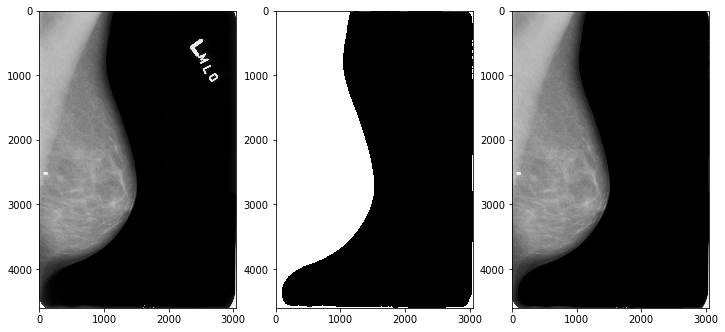

In [10]:
mammo_breast_mask = select_largest_obj(mammo_binary, lab_val=255, 
                                       fill_holes=False, 
                                       smooth_boundary=True, kernel_size=10)  # <<= para to tune!
mammo_arti_suppr = cv2.bitwise_and(mammo_med_blurred, mammo_breast_mask)
fig,axes = subplots(1, 3)
fig.set_size_inches([12, 9])
axes[0].imshow(mammo_med_blurred, cmap='gray')
axes[1].imshow(mammo_breast_mask, cmap='gray')
axes[2].imshow(mammo_arti_suppr, cmap='gray')
plt.savefig(cur_path+'/outcome/ArtifactSuppressedImg.jpg')

### Histogram Equalization - Contrast Enhancement
- It is a method that improves the contrast in an image, in order to stretch out the intensity range

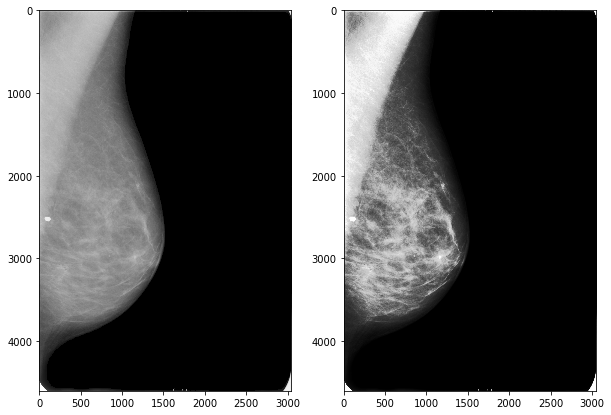

In [17]:
mammo_breast_equ = cv2.equalizeHist(mammo_arti_suppr)
fig,axes = subplots(1, 2)
fig.set_size_inches([10, 7])
axes[0].imshow(mammo_arti_suppr, cmap='gray')
axes[1].imshow(mammo_breast_equ, cmap='gray')
plt.savefig(cur_path+'/outcome/EqualizedImg.jpg')

### Thresholding the equalized image

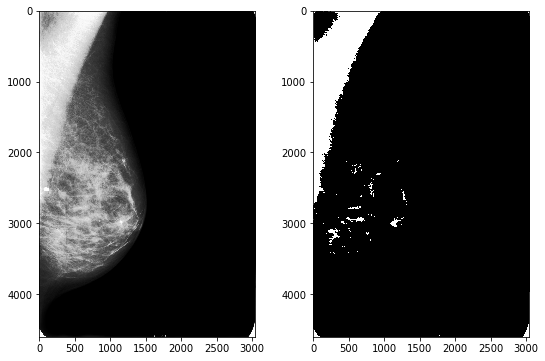

In [12]:
pect_high_inten_thres = 200  # <<= para to tune!
_, pect_binary_thres = cv2.threshold(mammo_breast_equ, pect_high_inten_thres, 
                                     maxval=255, type=cv2.THRESH_BINARY)
fig,axes = subplots(1, 2)
fig.set_size_inches([9, 6])
#res = hstack((mammo_med_blurred, mammo_binary))
axes[0].imshow(mammo_breast_equ, cmap='gray')
axes[1].imshow(pect_binary_thres, cmap='gray')
plt.savefig(cur_path+'/outcome/ThresholdingAgainImg.jpg')

### Eroding and Dilating

#### Erosion:
- Erodes away the boundaries of foreground object
- Used to diminish the features of an image.
- It is useful for removing small white noises

#### Dilation:
- Increases the object area
- Used to accentuate features
- Erosion removes white noises, but it also shrinks our object. Thus, with dilation noise won’t come back, but our object area increases.

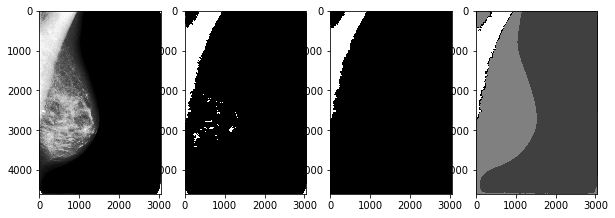

In [13]:

# Markers image for watershed algo.
pect_marker_img = np.zeros(pect_binary_thres.shape, dtype=np.int32)
# Sure foreground.
pect_mask_init = select_largest_obj(pect_binary_thres, lab_val=255, 
                                    fill_holes=False, smooth_boundary=True)
kernel_ = ones((3, 3), dtype=np.uint8)  # <<= para to tune!
n_erosions = 7  # <<= para to tune!
pect_mask_eroded = cv2.erode(pect_mask_init, kernel_, iterations=n_erosions)
pect_marker_img[pect_mask_eroded > 0] = 255
# Sure background - breast.
n_dilations = 7  # <<= para to tune!
pect_mask_dilated = cv2.dilate(pect_mask_init, kernel_, iterations=n_dilations)
pect_marker_img[pect_mask_dilated == 0] = 128
# Sure background - background.
pect_marker_img[mammo_breast_mask == 0] = 64


fig,axes = subplots(1, 4)
fig.set_size_inches([10, 14])
axes[0].imshow(mammo_breast_equ, cmap='gray')
axes[1].imshow(pect_binary_thres, cmap='gray')
axes[2].imshow(pect_mask_init, cmap='gray')
axes[3].imshow(pect_marker_img, cmap='gray')
plt.savefig(cur_path+'/outcome/ErosionAndDilationImg.jpg')

### Image marking and segmenting with Watershed

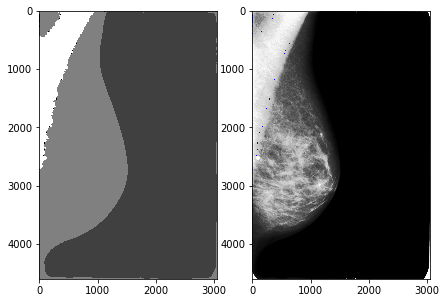

In [14]:
mammo_breast_equ_3c = cv2.cvtColor(mammo_breast_equ, cv2.COLOR_GRAY2BGR)
cv2.watershed(mammo_breast_equ_3c, pect_marker_img)
pect_mask_watershed = pect_marker_img.copy()
mammo_breast_equ_3c[pect_mask_watershed == -1] = (0, 0, 255)
pect_mask_watershed[pect_mask_watershed == -1] = 0
fig,axes = subplots(1, 2)
fig.set_size_inches([7, 6])
axes[0].imshow(pect_mask_watershed, cmap='gray')
axes[1].imshow(mammo_breast_equ_3c)
plt.savefig(cur_path+'/outcome/WatershedImg.jpg')

### Morphological Transformation and Masking:
- Same as Erosion and Dilation procedure
- MORPH_OPEN - Opening:
    - Erosion followed by Dilation. 
    - It is useful in removing noise
- MORPH_CLOSE - Closing:
    - Dilation followed by Erosion. 
    - It is useful in closing small holes inside the foreground objects, or small black points on the object
- MORPH_GRADIENT - Morphological Gradient:
    - It is the difference between dilation and erosion of an image. 
    - The result will look like the outline of the object
- MORPH_TOPHAT - Top Hat:
    - It is the difference between input image and Opening of the image
- MORPH_BLACKHAT - Black Hat:
    - It is the difference between the closing of the input image and input image
    
#### Masking - Bitwise Operations:
- It is highly useful while extracting any part of the image, defining and working with non-rectangular ROI 

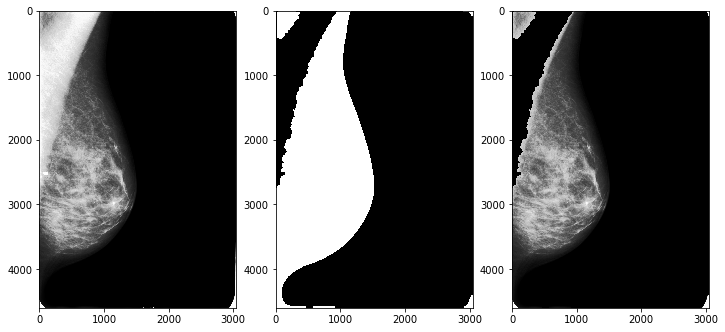

In [18]:
breast_only_mask = pect_mask_watershed.astype(np.uint8)
breast_only_mask[breast_only_mask != 128] = 0
breast_only_mask[breast_only_mask == 128] = 255
kn_size = 25  # <<= para to tune!
kernel_ = np.ones((kn_size, kn_size), dtype=np.uint8)
breast_only_mask_smo = cv2.morphologyEx(breast_only_mask, cv2.MORPH_OPEN, kernel_)
mammo_breast_only = cv2.bitwise_and(mammo_breast_equ, breast_only_mask_smo)
fig,axes = subplots(1, 3)
fig.set_size_inches([12, 9])
axes[0].imshow(mammo_breast_equ, cmap='gray')
axes[1].imshow(breast_only_mask_smo, cmap='gray')
axes[2].imshow(mammo_breast_only, cmap='gray')
plt.savefig(cur_path+'/outcome/MorphTransformImg.jpg')